<a href="https://colab.research.google.com/github/Tanvi030/FUTURE_DS_03/blob/main/Future_ds_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab setup: run once
!pip install -q textblob vaderSentiment wordcloud python-pptx
!pip install -q nltk spacy scikit-learn

# Download necessary NLP data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# (Optional) download textblob corpora if you plan to use TextBlob extensively
!python -m textblob.download_corpora

# Imports
import io, re, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sns.set(style="whitegrid")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 10.9 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


In [2]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/student_feedback.csv')


Mounted at /content/drive


In [3]:
df.head(5)
df.info()
df.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 10 columns):
 #   Column                                                Non-Null Count  Dtype
---  ------                                                --------------  -----
 0   Unnamed: 0                                            1001 non-null   int64
 1   Student ID                                            1001 non-null   int64
 2   Well versed with the subject                          1001 non-null   int64
 3   Explains concepts in an understandable way            1001 non-null   int64
 4   Use of presentations                                  1001 non-null   int64
 5   Degree of difficulty of assignments                   1001 non-null   int64
 6   Solves doubts willingly                               1001 non-null   int64
 7   Structuring of the course                             1001 non-null   int64
 8   Provides support for students going above and beyond  1001 non-null   int64
 9

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1001.0,500.000000,289.108111,0.0,250.0,500.0,750.0,1000.0
Student ID,1001.0,500.000000,289.108111,0.0,250.0,500.0,750.0,1000.0
Well versed with the subject,1001.0,7.497502,1.692998,5.0,6.0,8.0,9.0,10.0
Explains concepts in an understandable way,1001.0,6.081918,2.597168,2.0,4.0,6.0,8.0,10.0
Use of presentations,1001.0,5.942058,1.415853,4.0,5.0,6.0,7.0,8.0
Degree of difficulty of assignments,1001.0,5.430569,2.869046,1.0,3.0,5.0,8.0,10.0
Solves doubts willingly,1001.0,5.474525,2.874648,1.0,3.0,6.0,8.0,10.0
Structuring of the course,1001.0,5.636364,2.920212,1.0,3.0,6.0,8.0,10.0
Provides support for students going above and beyond,1001.0,5.662338,2.891690,1.0,3.0,6.0,8.0,10.0
Course recommendation based on relevance,1001.0,5.598402,2.886617,1.0,3.0,6.0,8.0,10.0


In [4]:
import re

def detect_rating_columns(df):
    candidates = []
    for c in df.columns:
        s = df[c].dropna().astype(str)
        # name hint
        if re.search(r'rating|score|satisfaction|stars|rate', c, re.I):
            candidates.append(c)
            continue
        # numeric hint: many values between 1 and 5
        numeric = pd.to_numeric(s.str.extract(r'(\d)', expand=False), errors='coerce')
        if numeric.between(1,5).mean() > 0.7:
            candidates.append(c)
    return candidates

def detect_comment_column(df):
    text_cols = [c for c in df.columns if df[c].dtype == 'object' or df[c].dtype.name=='string']
    best = None; best_score = 0
    for c in text_cols:
        avg_len = df[c].dropna().astype(str).str.len().mean() or 0
        uniq = df[c].dropna().nunique()
        score = avg_len * uniq
        if score > best_score:
            best_score = score; best = c
    return best

rating_candidates = detect_rating_columns(df)
comment_col = detect_comment_column(df)

print("Detected rating columns:", rating_candidates)
print("Detected comment column:", comment_col)


Detected rating columns: []
Detected comment column: None


In [5]:
rating_col = 'Overall Rating'   # replace
comment_col = 'Additional Comments'  # replace


In [7]:
# example: pick first detected rating
rating_col = 'Well versed with the subject' # Change 'rating' to an existing rating column name

# extract a single digit 1-5 from text like "5/5" or "4 - good"
df['rating'] = pd.to_numeric(df[rating_col].astype(str).str.extract(r'([1-5])', expand=False), errors='coerce')
# keep only 1-5 or NaN
df.loc[~df['rating'].between(1,5), 'rating'] = np.nan

# summary
print(df['rating'].describe())
print(df['rating'].value_counts(dropna=False).sort_index())

count    318.000000
mean       3.075472
std        2.001725
min        1.000000
25%        1.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64
rating
1.0    153
5.0    165
NaN    683
Name: count, dtype: int64


In [9]:
print(df.columns.tolist())


['Unnamed: 0', 'Student ID', 'Well versed with the subject', 'Explains concepts in an understandable way', 'Use of presentations', 'Degree of difficulty of assignments', 'Solves doubts willingly', 'Structuring of the course', 'Provides support for students going above and beyond', 'Course recommendation based on relevance', 'rating']


In [10]:
# Ensure numeric ratings
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
print(df['rating'].describe())


count    318.000000
mean       3.075472
std        2.001725
min        1.000000
25%        1.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64


In [11]:
# List of all feedback columns (excluding IDs)
feedback_cols = [
 'Well versed with the subject',
 'Explains concepts in an understandable way',
 'Use of presentations',
 'Degree of difficulty of assignments',
 'Solves doubts willingly',
 'Structuring of the course',
 'Provides support for students going above and beyond',
 'Course recommendation based on relevance',
 'rating'
]

# Convert to numeric
for col in feedback_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Quick stats
df[feedback_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Well versed with the subject,1001.0,7.497502,1.692998,5.0,6.0,8.0,9.0,10.0
Explains concepts in an understandable way,1001.0,6.081918,2.597168,2.0,4.0,6.0,8.0,10.0
Use of presentations,1001.0,5.942058,1.415853,4.0,5.0,6.0,7.0,8.0
Degree of difficulty of assignments,1001.0,5.430569,2.869046,1.0,3.0,5.0,8.0,10.0
Solves doubts willingly,1001.0,5.474525,2.874648,1.0,3.0,6.0,8.0,10.0
Structuring of the course,1001.0,5.636364,2.920212,1.0,3.0,6.0,8.0,10.0
Provides support for students going above and beyond,1001.0,5.662338,2.891690,1.0,3.0,6.0,8.0,10.0
Course recommendation based on relevance,1001.0,5.598402,2.886617,1.0,3.0,6.0,8.0,10.0
rating,318.0,3.075472,2.001725,1.0,1.0,5.0,5.0,5.0


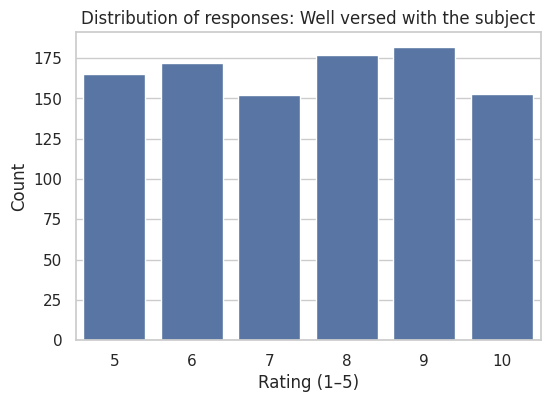

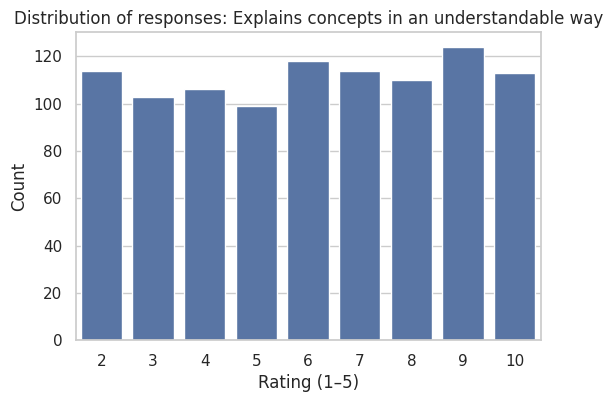

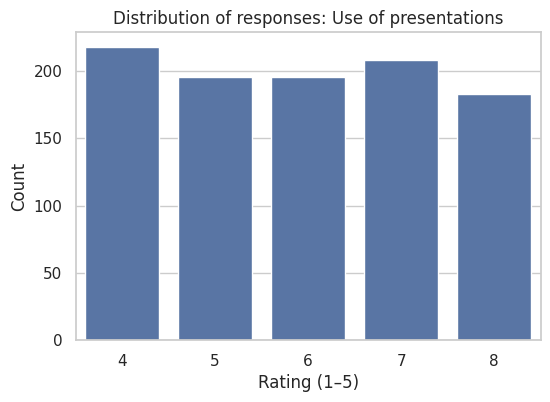

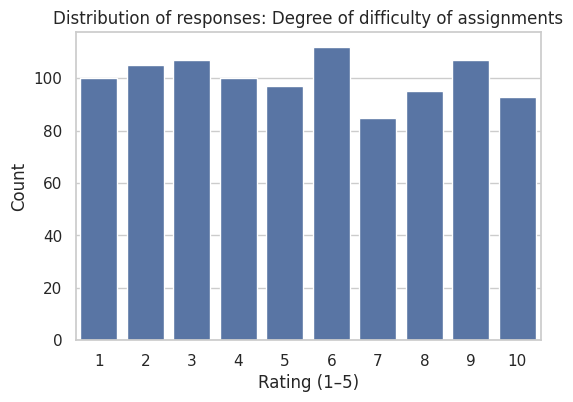

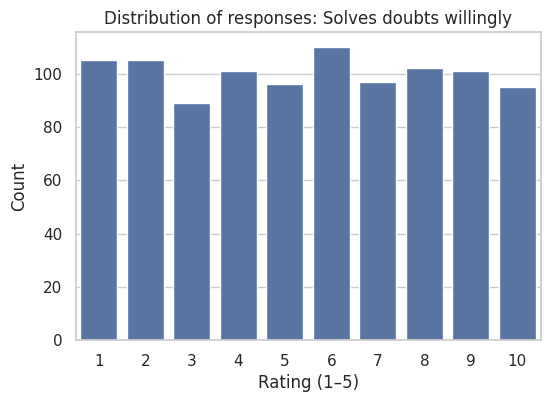

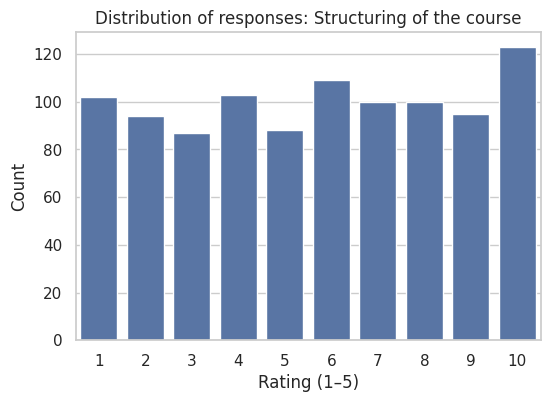

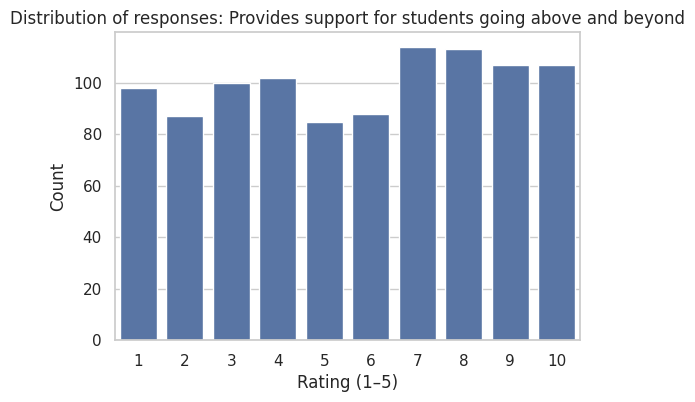

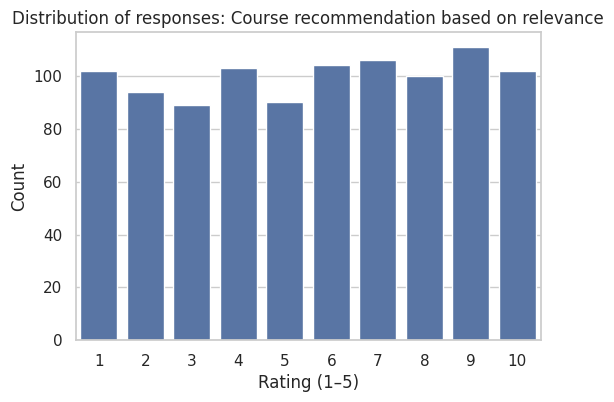

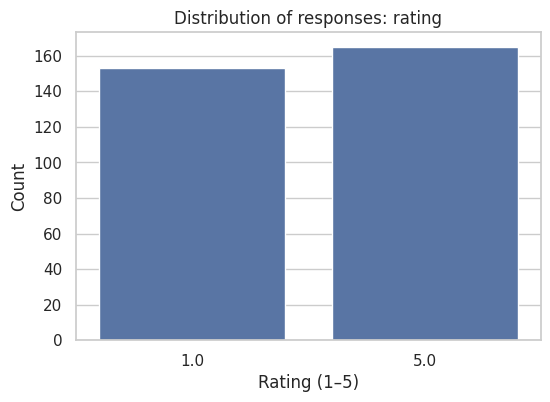

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in feedback_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, order=sorted(df[col].dropna().unique()))
    plt.title(f'Distribution of responses: {col}')
    plt.xlabel('Rating (1–5)')
    plt.ylabel('Count')
    plt.show()


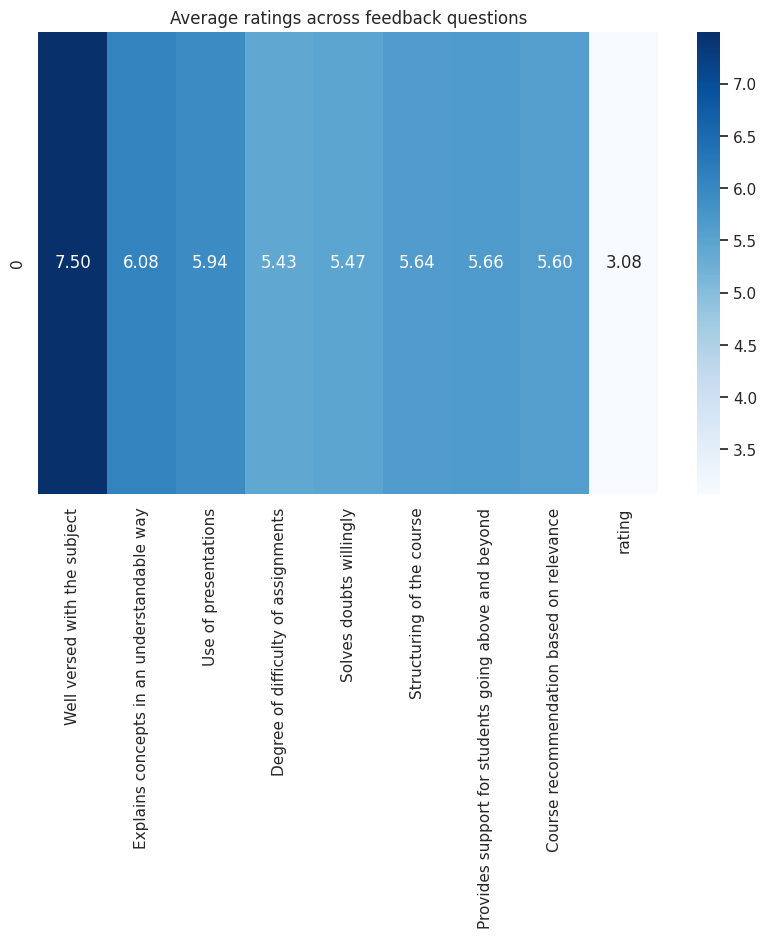

In [13]:
plt.figure(figsize=(10,6))
sns.heatmap(df[feedback_cols].mean().to_frame().T, annot=True, cmap="Blues", fmt=".2f")
plt.title("Average ratings across feedback questions")
plt.show()


In [14]:
avg_scores = df[feedback_cols].mean().sort_values()
print("Lowest scoring aspects:")
print(avg_scores.head(3))


Lowest scoring aspects:
rating                                 3.075472
Degree of difficulty of assignments    5.430569
Solves doubts willingly                5.474525
dtype: float64


In [15]:
# --- Generate strengths & improvements automatically ---

# Compute average score per question
avg_scores = df[feedback_cols].mean().sort_values(ascending=False)

# Top 3 strengths
top_strengths = avg_scores.head(3)

# Top 3 areas needing improvement
top_weaknesses = avg_scores.tail(3)

print("✅ Top Strengths (highest average ratings):\n")
for q, score in top_strengths.items():
    print(f"- {q}: {score:.2f}/5")

print("\n⚠️ Areas to Improve (lowest average ratings):\n")
for q, score in top_weaknesses.items():
    print(f"- {q}: {score:.2f}/5")


✅ Top Strengths (highest average ratings):

- Well versed with the subject: 7.50/5
- Explains concepts in an understandable way: 6.08/5
- Use of presentations: 5.94/5

⚠️ Areas to Improve (lowest average ratings):

- Solves doubts willingly: 5.47/5
- Degree of difficulty of assignments: 5.43/5
- rating: 3.08/5


In [21]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = set(stopwords.words('english'))

def clean_text(s):
    if not isinstance(s, str): return ''
    s = s.lower()
    s = re.sub(r'http\S+|www\.\S+', ' ', s)   # remove URLs
    s = re.sub(r'\S+@\S+', ' ', s)            # remove emails
    s = re.sub(r'[^a-z0-9\s]', ' ', s)        # keep letters/numbers
    s = re.sub(r'\s+', ' ', s).strip()
    tokens = [w for w in s.split() if w not in stop and len(w) > 2]
    return ' '.join(tokens)

df[feedback_cols] = df[feedback_cols].fillna('').apply(clean_text)  # replace "Comments" with your column name


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/tmp/ipython-input-1393164871.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df[feedback_cols] = df[feedback_cols].fillna('').apply(clean_text)  # replace "Comments" with your column name


                                                    count  mean  std  min  \
Well versed with the subject                          0.0   NaN  NaN  NaN   
Explains concepts in an understandable way            0.0   NaN  NaN  NaN   
Use of presentations                                  0.0   NaN  NaN  NaN   
Degree of difficulty of assignments                   0.0   NaN  NaN  NaN   
Solves doubts willingly                               0.0   NaN  NaN  NaN   
Structuring of the course                             0.0   NaN  NaN  NaN   
Provides support for students going above and b...    0.0   NaN  NaN  NaN   
Course recommendation based on relevance              0.0   NaN  NaN  NaN   
rating                                                0.0   NaN  NaN  NaN   

                                                    25%  50%  75%  max  
Well versed with the subject                        NaN  NaN  NaN  NaN  
Explains concepts in an understandable way          NaN  NaN  NaN  NaN  
Use of pre

/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.12/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


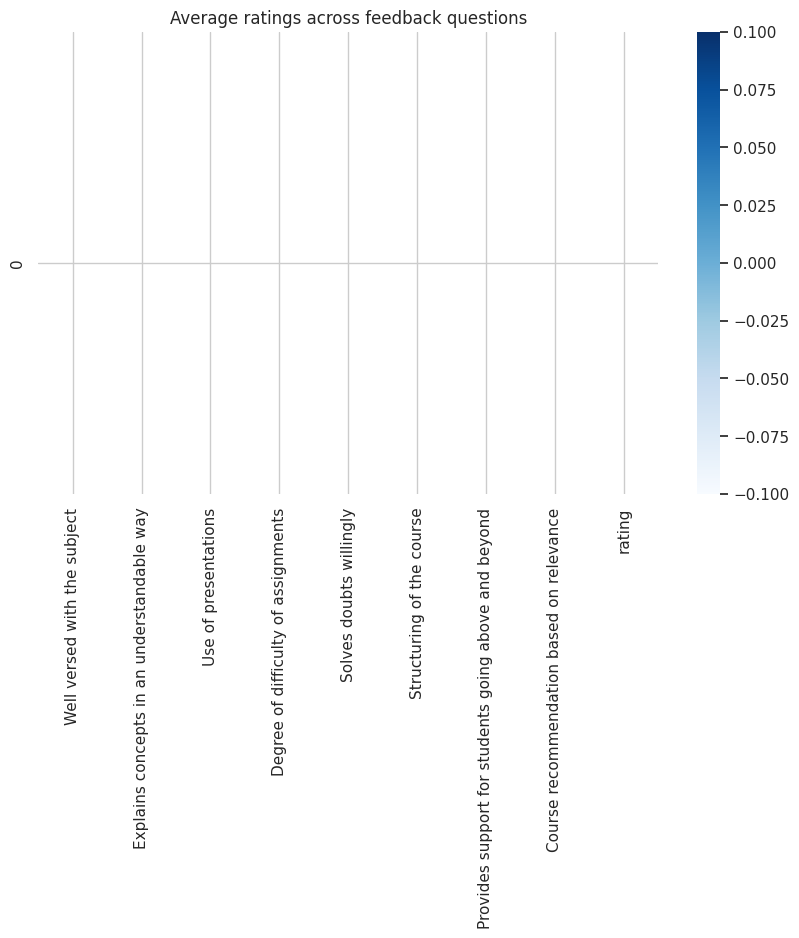

In [26]:
# Define feedback columns
feedback_cols = [
 'Well versed with the subject',
 'Explains concepts in an understandable way',
 'Use of presentations',
 'Degree of difficulty of assignments',
 'Solves doubts willingly',
 'Structuring of the course',
 'Provides support for students going above and beyond',
 'Course recommendation based on relevance',
 'rating'
]

# Convert to numeric just in case
for col in feedback_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Summary stats
print(df[feedback_cols].describe().T)

# Average scores
avg_scores = df[feedback_cols].mean().sort_values(ascending=False)
print("\nTop Strengths:")
print(avg_scores.head(3))
print("\nAreas to Improve:")
print(avg_scores.tail(3))

# Visualization — heatmap of averages
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df[feedback_cols].mean().to_frame().T, annot=True, cmap="Blues", fmt=".2f")
plt.title("Average ratings across feedback questions")
plt.show()


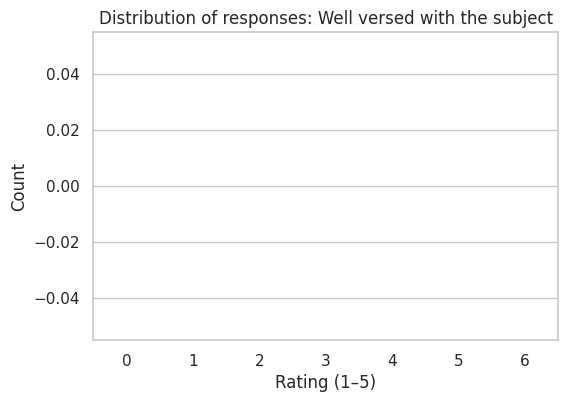

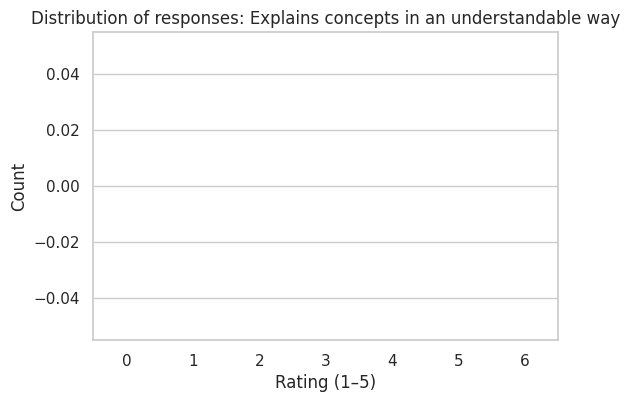

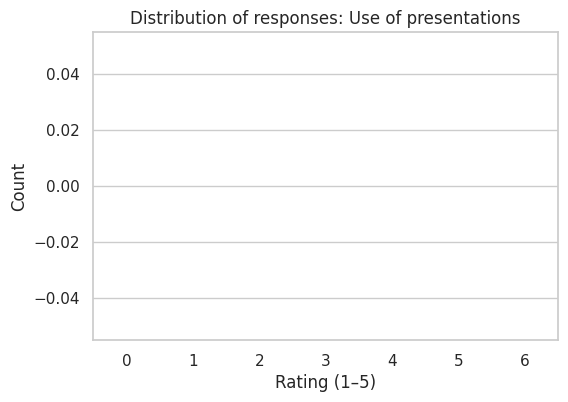

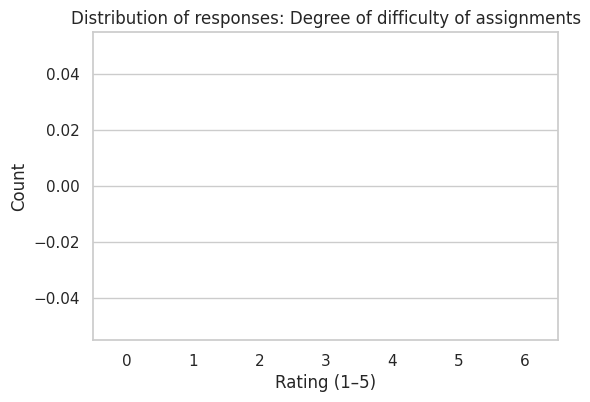

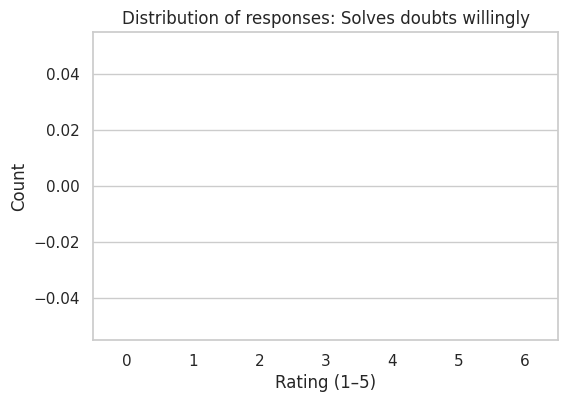

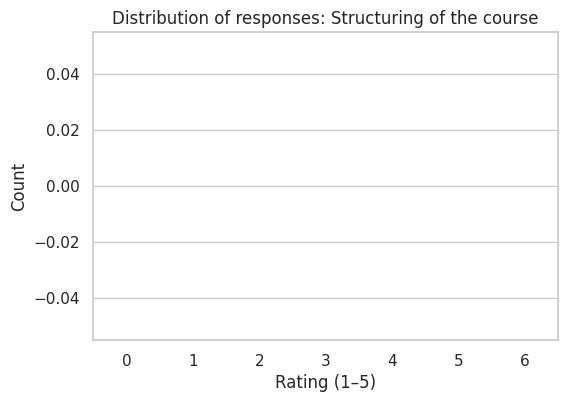

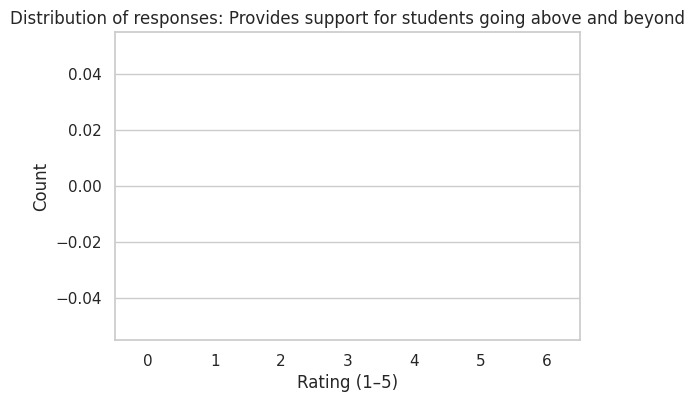

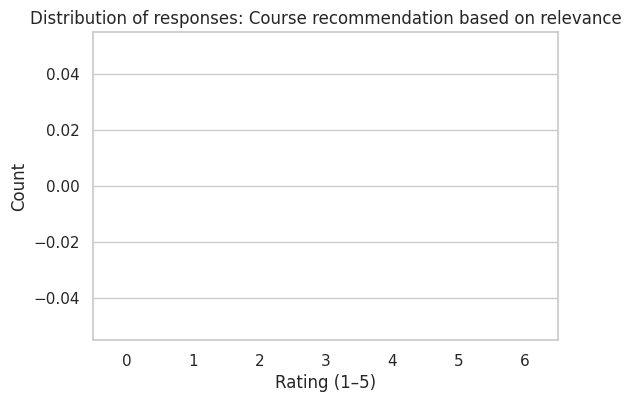

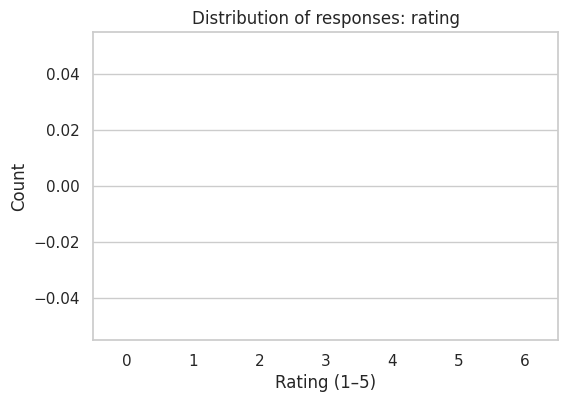

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

for col in feedback_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, data=df, order=sorted(df[col].dropna().unique()))
    plt.title(f'Distribution of responses: {col}')
    plt.xlabel('Rating (1–5)')
    plt.ylabel('Count')
    plt.show()


In [28]:
if 'Timestamp' in df.columns:
    df['ts'] = pd.to_datetime(df['Timestamp'], errors='coerce')
    daily_avg = df.groupby(df['ts'].dt.date)['rating'].mean().reset_index()
    plt.figure(figsize=(10,4))
    sns.lineplot(data=daily_avg, x='ts', y='rating', marker='o')
    plt.title('Average rating over time')
    plt.xlabel('Date')
    plt.ylabel('Mean rating')
    plt.show()


In [42]:
# Save the processed DataFrame to an Excel file
df.to_excel('/content/feedback_processed.xlsx', index=False)

from google.colab import files

files.download('/content/feedback_processed.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>